# Otimização em ação

<center>
Francisco Nogueira Calmon Sobral<BR>
Universidade Estadual de Maringá - PR - Brasil<BR>
ERMAC PR - 07 de Maio de 2025
</center>

Este trabalho foi feito com a ajuda de

  - Anderson Ervino Schwertner
  - Joaquim Gabriel Martins

e foi inteiramente baseado no artigo

> PERALTA, J., ANDRETTA, M., OLIVEIRA, J. **Packing Circles and Irregular Polygons using Separation Lines**. Proceedings of the 7th International Conference on Operations Research and Enterprise Systems (ICORES 2018), 71-77, 2018.

In [3]:
using Pkg

Pkg.activate("../ermacpr25")
Pkg.instantiate()

  Activating project at `~/personal/working/minicurso-empacotamento/ermacpr25`


In [5]:
using Plots, LinearAlgebra, JuMP, Ipopt

In [12]:
include("../ermacpr25/src/ermacpr25.jl")

desenha_solucao_qc (generic function with 1 method)

  - Um círculo $i \in \mathcal{C}$ será definido pelas coordenadas do seu centro $(x^C_i, y^C_i)$ e seu raio $r_i$.
  - Um polígono $i \in \mathcal{P}$ será definido pela rotação $\theta_i$ e deslocamento $(x^P_i, y_i^P)$ aplicadas em um **polígono-base** $B_i$
      - O polígono base $B_i$ é formado pela união de $p_i$ polígonos convexos $P^i_1, P^i_2, \dots, P^i_{p_i}$
      - Cada $P^i_j$ convexo é formado por $v^i_j$ vértices $(v^{i, j, k}_x, v^{i, j, k}_y)$
      - Dados $\theta_i$ e $(x^P_i, y_i^P)$, denotaremos por $D_i$ a operação de rotação seguida de deslocamento

In [9]:
P = [
        [ # Poligono 1
            [0.0 1.155; -0.866 -0.577; 0.866 -0.577; 0.0 -1.155; -0.866 0.577; 0.866 0.577]
        ],
        [  # Poligono 2
            [0.0 0.0; 2.0 0.0; 2.0 2.0; 0.0 2.0]
        ], 
        [  # Poligono 3
            [4.0 0.0; 6.0 0.0; 7.0 1.73; 6.0 3.46; 4.0 3.46; 3.0 1.73]
        ],
        [ # Poligono 4
            [8.0 2.0; 10.0 0.0; 11.0 2.0; 9.0 3.0],
            [10.0 0.0; 16.0 3.0; 15.0 4.0; 11.0 2.0]
        ],
        [ # Poligono 5
            [0.0 0.0; 2.0 0.0; 1.5 1.5]
        ],
        [ # Poligono 6
            [0.0 0.0; 2.0 0.0; 2.0 2.0; 1.0 3.0; 3.0 3.0; 4.0 2.0; 3.0 1.0; 1.0 1.0]
        ]
];

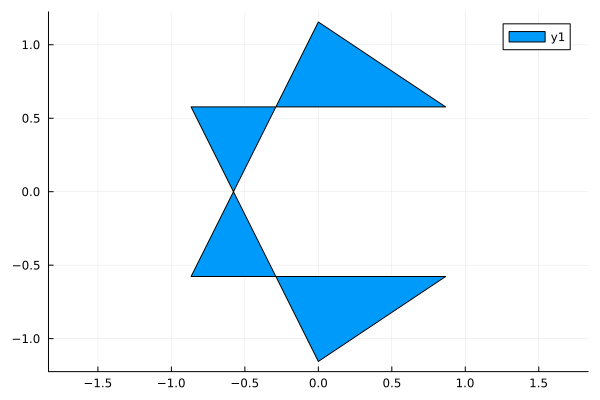

In [18]:
plot(uniao_poligonos(P[1]), aspect_ratio=true)

### Sobreposição entre círculos

$$
(x^C_i - x^C_j)^2 + (y^C_i - y^C_j)^2 \ge (r_i + r_j)^2
$$

### Alocação de círculos em retângulos

Considerando que o retângulo possui lados $W \times L$ e o vértice inferior esquerdo é a origem
$$
\begin{split}
r_i \le x^C_i & \le W - r_i \\
r_i \le y^C_i & \le L - r_i 
\end{split}
$$

Polígonos
$$

$$



In [ ]:
# Pacotes e funções úteis:

function cosseno_model_teste!(model, poligonos, ang, xP, yP)
    np = length(poligonos)
    nalpha = length(ang)
    nx = length(xP)
    ny = length(yP)
    nley = Vector{Any}(undef, np)
    nlex = Vector{Any}(undef, np)
    for i = 1:np
        nlex[i] = @NLexpression(model, [n = 1:length(poligonos[i]), h = 1:size(poligonos[i][n])[1]], 
                        poligonos[i][n][h, 1] * cos(ang[i]) - poligonos[i][n][h, 2] * sin(ang[i]) + xP[i])

        nley[i] = @NLexpression(model, [n = 1:length(poligonos[i]), h = 1:size(poligonos[i][n])[1]], 
                        poligonos[i][n][h, 1] * sin(ang[i]) + poligonos[i][n][h, 2] * cos(ang[i]) + yP[i])
    end
    return nlex, nley
end


function cdij!(model, reta, alpha_L, xL, yL)
    nr = length(reta)
    nlerc = Array{Any}(undef, nr)
    nlerd = Array{Any}(undef, nr)
    for i = 1:nr-1
        nlerc[i] = Array{Any}(undef, length(reta[i]))
        nlerd[i] = Array{Any}(undef, length(reta[i]))
        noutrascc = 0
        for j = i+1:nr
            if (reta[j]) != 0
                noutrascc += length(reta[j])
            end
        end
        for h = 1:length(reta[i])
            nlerc[i][h] = Array{Any}(undef, noutrascc)
            nlerd[i][h] = Array{Any}(undef, noutrascc)
            k = 0
            for n = i+1:nr # Fixa o Pol_j
                for l = 1:length(reta[n]) # Seleciona a l-esima comp. convexa do Pol_j
                    k += 1
                    nlerc[i][h][k] = @NLexpression(model, ((reta[i][h][2, 1] - reta[i][h][1, 1]) * sin(alpha_L[i,h,k]) + (reta[i][h][2, 2] - reta[i][h][1, 2]) * cos(alpha_L[i,h,k])) /
                                            ((reta[i][h][2, 1] - reta[i][h][1, 1]) * cos(alpha_L[i,h,k]) + (reta[i][h][1, 2] - reta[i][h][2, 2]) * sin(alpha_L[i,h,k])))
                    nlerd[i][h][k] = @NLexpression(model, yL[i,h,k] - nlerc[i][h][k] * xL[i,h,k])
                end
            end
        end
    end
    return nlerc, nlerd
end


function cdij_circ!(model, reta, alpha_L_circ, xL_circ, yL_circ, raio)
    nr = length(reta)
    nc = length(raio)
    nlerc_circ = Array{Any}(undef, nr)
    nlerd_circ = Array{Any}(undef, nr)
    
    for i = 1:nr
        nlerc_circ[i] = Array{Any}(undef, length(reta[i]))
        nlerd_circ[i] = Array{Any}(undef, length(reta[i]))
        noutrascc = 0
        
        for j = 1:nc
            noutrascc += 1
        end
        
        for h = 1:length(reta[i])
            nlerc_circ[i][h] = Array{Any}(undef, noutrascc)
            nlerd_circ[i][h] = Array{Any}(undef, noutrascc)
            k = 0
            
            for n = 1:nc # Fixa o circ
                k += 1
                nlerc_circ[i][h][k] = @NLexpression(model, ((reta[i][h][2, 1] - reta[i][h][1, 1]) * sin(alpha_L_circ[i,h,k]) + (reta[i][h][2, 2] - reta[i][h][1, 2]) * cos(alpha_L_circ[i,h,k])) /
                                            ((reta[i][h][2, 1] - reta[i][h][1, 1]) * cos(alpha_L_circ[i,h,k]) + (reta[i][h][1, 2] - reta[i][h][2, 2]) * sin(alpha_L_circ[i,h,k])))
                nlerd_circ[i][h][k] = @NLexpression(model, yL_circ[i,h,k] - nlerc_circ[i][h][k] * xL_circ[i,h,k])
            end
        end
    end
    
    return nlerc_circ, nlerd_circ
end









function constraints!(model,poligonos,nlex,nley,nlerc,nlerd,l,w)
for i = 1:length(poligonos)
 nle_x = nlex[i]
 nle_y = nley[i]
 @NLconstraint(model, [n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]], nle_x[n,h] >= 0 )
 @NLconstraint(model,[n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]],  nle_y[n,h] >= 0  )
 @NLconstraint(model, [n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]], nle_x[n,h] <= w )
 @NLconstraint(model,[n =1:length(poligonos[i]), h =1:size(poligonos[i][n])[1]],  nle_y[n,h] <= l )       
end
end
#ok

function n_sobreposicao!(model, poligonos, reta, nlex, nley, nlerc, nlerd)
    for i = 1:length(poligonos)-1
          print(i)
        nle_x = nlex[i]
        nle_y = nley[i]
        k=0
        for h = 1:length(poligonos[i])
           
            c = nlerc[i][h]
            d = nlerd[i][h]
             k =0
            for n = i+1:length(poligonos)
                nle_xj = nlex[n]
                nle_yj = nley[n]
                for l = 1:length(poligonos[n])
                    k +=1
                    for q = 1:size(poligonos[i][h], 1)
                        
                          @NLconstraint(model, nle_y[h,q] - c[k]*nle_x[h,q] - d[k] <= 0.0)
                     
                    end
                    for q = 1:size(poligonos[n][l], 1)
                        
                          @NLconstraint(model, nle_yj[l,q] - c[k]*nle_xj[l,q] - d[k] >= 0.0)
                     
                    end
#                  
                end
                
            end
            
            
        end
    end
    return model
end


#ok



function contcir!(model,raios,xC,yC,l,w)
#colocar l e w como variável local
for i=1:length(xC)
    @NLconstraint(model, 0<= xC[i]- raios[i]  )
    @NLconstraint(model,  0<= yC[i]- raios[i]  )
    @NLconstraint(model,  raios[i]+xC[i] <= w)
    @NLconstraint(model,  raios[i]+yC[i] <= l)
    @NLconstraint(model, xC[i] >= 0)
    @NLconstraint(model, yC[i] >= 0)
end
 return model
end
#ok



function nsobrecirc!(model,Xc,yC,raios)
for i= 1:length(xC)
    for j= i+1:length(xC)
        @NLconstraint(model, (xC[i] - xC[j])^2.0 + (yC[i] - yC[j])^2.0 >= (raios[i] + raios[j])^2.0)
    end
end
return model
end    
#ok    
    
function delta!(model, poligonos, xC, yC, nlerc_circ, nlerd_circ, raios)
        for i = 1:length(poligonos)
            for h = 1:length(poligonos[i])
                k = 0
                for q = 1:length(xC) 
                    k += 1
                    c = nlerc_circ[i][h][k]
                    d = nlerd_circ[i][h][k]
                    @NLconstraint(model,  0 <= c*xC[q]- yC[q]+ d )
                    @NLconstraint(model, (c*xC[q]- yC[q]+ d)^2  >= (raios[q]^2)*(c ^ 2.0 + 1.0) )
                    
                end
            end
        end
    
    return model
end

                    
function last_re!(model, poligonos, xC, yC, nlerc_circ, nlerd_circ, nlex, nley)
   for i = 1:length(poligonos)
         for h = 1:length(poligonos[i])
                k = 0
                for q = 1:length(xC) 
                    k += 1
                    c = nlerc_circ[i][h][k]
                    d = nlerd_circ[i][h][k]
                    for f = 1:size(poligonos[i][h], 1)
                        @NLconstraint(model, nley[i][h,f] - c*nlex[i][h,f] - d >= 0)
                    end     
                end
            end
        end
    
    return model
end



┌ Warning: Module ColorVectorSpace with build ID fafbfcfd-29ba-808f-0000-042b983cf1a4 is missing from the cache.
│ This may mean ColorVectorSpace [c3611d14-8923-5661-9e6a-0046d554d3a4] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2018


last_re! (generic function with 1 method)

In [5]:
circ_r = [2.0; 3.0; 5.0]
lista_poligonos = [[[0.0 1.155; -0.866 -0.577; 0.866 -0.577; 0.0 -1.155; -0.866 0.577; 0.866 0.577]],
    [[0.0 0.0; 2.0 0.0; 2.0 2.0; 0.0 2.0]], 
    [[4.0 0.0; 6.0 0.0; 7.0 1.73; 6.0 3.46; 4.0 3.46; 3.0 1.73]],
    [[8.0 2.0; 10.0 0.0; 11.0 2.0; 9.0 3.0], [10.0 0.0; 16.0 3.0; 15.0 4.0; 11.0 2.0]], [[0.0 0.0; 2.0 0.0; 1.5 1.5]],
    [[0.0 0.0; 2.0 0.0; 2.0 2.0; 1.0 3.0; 3.0 3.0; 4.0 2.0; 3.0 1.0; 1.0 1.0]]

    
]
L = 20
W = 20
lista_rotacionada =translacao_poligono(lista_poligonos)
rt = reta(lista_rotacionada)
rt = reta(lista_rotacionada)
nr = length(rt)
nc = length(circ_r)



#MODELO
model = Model(Ipopt.Optimizer)
    
    # Variáveis das coordenadas de referência
    @variable(model, xC[i = 1:length(circ_r)])
    @variable(model, yC[i = 1:length(circ_r)])
    @variable(model, xP[i = 1:nr])
    @variable(model, yP[1:nr])
    @variable(model, theta_P[1:nr])

    # Componentes da reta para comparação de polígonos
    @variable(model, yL[i = 1:nr-1, h = 1:length(rt[i]), n = 1:sum(length(rt[j]) for j = i+1:nr)], start = rand())
    @variable(model, xL[i = 1:nr-1, h = 1:length(rt[i]), n = 1:sum(length(rt[j]) for j = i+1:nr)], start=rand())
    @variable(model, alpha_L[i = 1:nr-1, h = 1:length(rt[i]), n = 1:sum(length(rt[j]) for j = i+1:nr)], start=rand())

    # Componentes da reta para o delta
    @variable(model, yL_circ[i = 1:nr, h = 1:length(rt[i]), n = 1:nc], start = rand())
    @variable(model, xL_circ[i = 1:nr, h = 1:length(rt[i]), n = 1:nc], start=rand())
    @variable(model, alpha_L_circ[i = 1:nr, h = 1:length(rt[i]), n =1:nc], start=rand())
    
    nlex, nley = cosseno_model_teste!(model, lista_rotacionada, theta_P, xP, yP)
    nlerc, nlerd = cdij!(model, rt, alpha_L, xL, yL)
    nlerc_circ, nlerd_circ = cdij_circ!(model, rt, alpha_L_circ, xL_circ, yL_circ, circ_r)
    
    # Restrições de contenção
    contcir!(model, circ_r, xC, yC, L, W)
    nsobrecirc!(model, xC, yC, circ_r)
    constraints!(model, lista_rotacionada, nlex, nley, nlerc, nlerd, L, W)  
    
    # Restrições de não sobreposição
    n_sobreposicao!(model, lista_rotacionada, rt, nlex, nley, nlerc, nlerd)
    delta!(model, lista_rotacionada, xC, yC, nlerc_circ, nlerd_circ, circ_r)
    last_re!(model, lista_rotacionada, xC, yC, nlerc_circ, nlerd_circ, nlex, nley)
    
    @objective(model, Min, 0)
    
    # Chama o otimizador Ipopt:
    optimize!(model)


# Chama o otimizador Ipopt:
status = optimize!(model)


12345
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2362
Number of nonzeros in Lagrangian Hessian.............:     3034

Total number of variables............................:      147
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequal

In [6]:
xP_values = value.(xP)
yP_values = value.(yP)
theta_P_values = value.(theta_P)
xL_values = value.(xL)
yL_values = value.(yL)
alpha_L_values = value.(alpha_L)
xC_values = value.(xC)
yC_values = value.(yC)
print(xP_values)

[2.289138647893646, 4.511458761733861, 0.24197335155211452, 5.795483086783777, 14.34014747078436, 8.291270282490439]

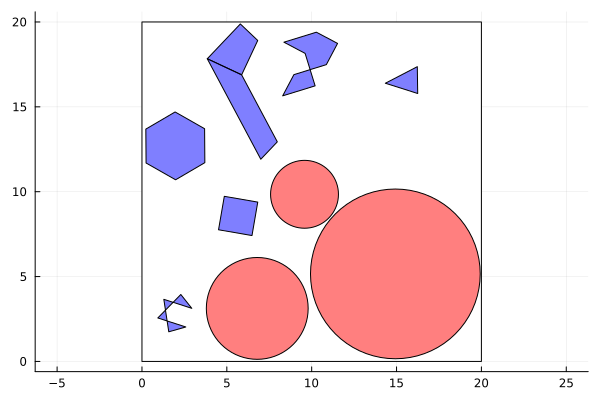

In [7]:
#x =[xC_values[1],yC_values[1],xP_values[1], yP_values[1], theta_P_values[1],xP_values[2], yP_values[2], theta_P_values[2]]
#print(x)
z = [ [[i, j] for (i, j) in zip(xC_values, yC_values)]; 
      [[i, j, k] for (i, j, k) in zip(xP_values, yP_values, theta_P_values)] ]
z = vcat(z...)
#print(z)
plota_solucao(circ_r,lista_rotacionada,L, W, z)